In [ ]:
#Importação das bibliotecas a serem usadas
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar CSVs como DataFrames pandas
df_dict = pd.read_csv(r'C:\Users\Aluno\Documents\GitHub\final-project\data\P18_dicionario_dados.csv', encoding='utf-8', sep=',')
df_cancel = pd.read_csv(r'C:\Users\Aluno\Documents\GitHub\final-project\data\P18_cancelamentos.csv', encoding='utf-8', sep=',')
df_contratos = pd.read_csv(r'C:\Users\Aluno\Documents\GitHub\final-project\data\P18_contratos.csv', encoding='utf-8', sep=',')
df_clientes = pd.read_csv(r'C:\Users\Aluno\Documents\GitHub\final-project\data\P18_clientes.csv', encoding='utf-8', sep=',')

# Criar banco SQLite em memória (ou em disco se preferir salvar como arquivo)
conn = sqlite3.connect(":memory:")  # ou 'meubanco.db' se quiser salvar em disco

# Registrar os DataFrames como tabelas SQL dentro do SQLite
df_cancel.to_sql("cancelamentos", conn, index=False, if_exists="replace")
df_contratos.to_sql("contratos", conn, index=False, if_exists="replace")
df_clientes.to_sql("clientes", conn, index=False, if_exists="replace")

5000

In [2]:
import sys
print(sys.executable)

c:\ProgramData\anaconda3\python.exe


1. Quantos planos de seguro temos?

In [3]:
df_contratos['tipo_seguro'].nunique()
df_contratos['tipo_seguro'].value_counts()

tipo_seguro
Auto           2429
Empresarial    2423
Vida           2406
Saúde          2390
Residencial    2352
Name: count, dtype: int64

Total: 12000 planos de seguro.

2. Quais planos possuem mais cancelamento?

In [4]:
# Unir Contratos com Cancelamentos
df_cancelados = df_contratos.merge(df_cancel, on='id_contrato', how='inner')

# Contar Cancelamentos por Tipo de Seguro
df_cancelados['tipo_seguro'].value_counts()

tipo_seguro
Saúde          528
Empresarial    522
Residencial    512
Vida           489
Auto           469
Name: count, dtype: int64

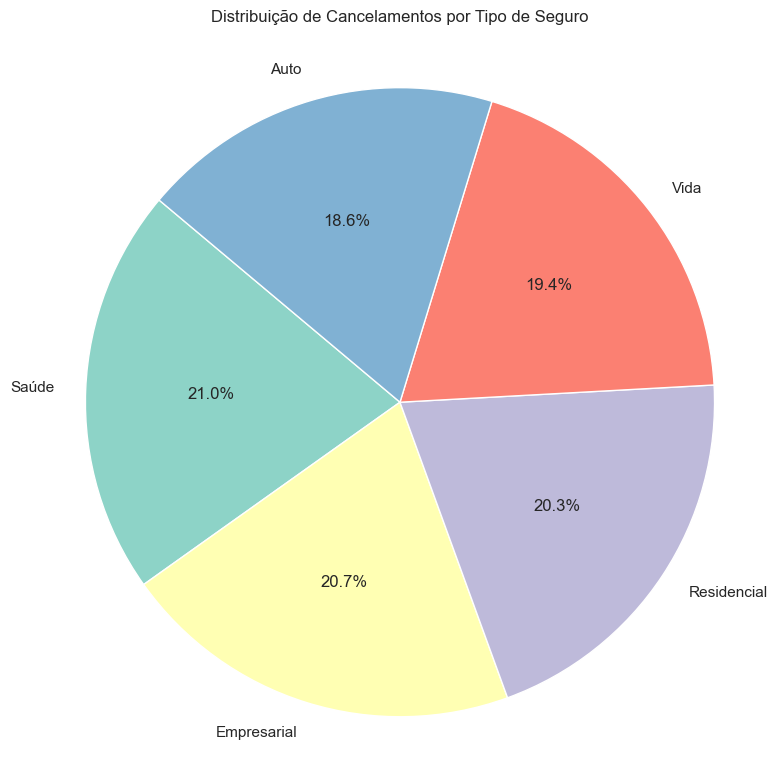

In [39]:
#Contagem de cancelamentos por tipo de seguro
cancelamentos_por_tipo = df_cancelados['tipo_seguro'].value_counts()

# Gráfico de Pizza
plt.figure(figsize=(8, 8))
plt.pie(cancelamentos_por_tipo, labels=cancelamentos_por_tipo.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Set3.colors)
plt.title('Distribuição de Cancelamentos por Tipo de Seguro')
plt.axis('equal')  # Mantém o gráfico como um círculo
plt.tight_layout()
plt.show()

Os planos com mais cancelamentos são saúde, empresarial e residencial, embora a amplitude entre os planos seja relativamente mínima.

3. Qual o tempo de contrato médio dos clientes?

In [5]:
# Converter Datas
df_contratos['data_inicio'] = pd.to_datetime(df_contratos['data_inicio'])
df_contratos['data_fim'] = pd.to_datetime(df_contratos['data_fim'])

# Criar Coluna com Duração em Dias
df_contratos['duracao_contrato'] = (df_contratos['data_fim'] - df_contratos['data_inicio']).dt.days

# Média Geral
df_contratos['duracao_contrato'].mean()

424.2079166666667

O tempo médio dos clientes é, em sua maioria, um ano e dois meses.

4. Qual o tempo médio dos contratos cancelados?

In [6]:
df_cancelados['data_inicio'] = pd.to_datetime(df_cancelados['data_inicio'])
df_cancelados['data_fim'] = pd.to_datetime(df_cancelados['data_fim'])

df_cancelados['duracao_contrato'] = (df_cancelados['data_fim'] - df_cancelados['data_inicio']).dt.days
df_cancelados['duracao_contrato'].mean()

415.67857142857144

O tempo médio dos clientes que cancelas é muito similar ao dos clientes gerais, sendo inferior em apenas uma semana e 2 dias.

5. Houve troca de plano antes do cancelamento?

In [7]:
# Ver Clientes com Mais de um Tipo de Seguro
df_contratos.sort_values(by=['id_cliente', 'data_inicio'], inplace=True)
df_troca = df_contratos.groupby('id_cliente')['tipo_seguro'].nunique()

# Clientes que Já Tiveram Mais de um Tipo
trocaram = df_troca[df_troca > 1].index

# Quantos Desses Também Cancelaram
cancelaram_e_trocaram = df_cancelados[df_cancelados['id_cliente'].isin(trocaram)]
print("Cancelaram após trocar de plano:", len(cancelaram_e_trocaram))

Cancelaram após trocar de plano: 2184


Esse valor representa cerca de 87% dos clientes que eventualmente cancelaram, logo, a grande maioria trocou de plano antes do cancelamento.

6. Clientes que renovaram contrato ao menos uma vez cancelam menos?

In [8]:
# Clientes que Renovaram
renovaram = df_contratos[df_contratos['renovado_automaticamente'] == True]
nao_renovaram = df_contratos[df_contratos['renovado_automaticamente'] == False]

# Com Cancelamento
renovaram_cancelaram = renovaram[renovaram['id_contrato'].isin(df_cancel['id_contrato'])]
nao_renovaram_cancelaram = nao_renovaram[nao_renovaram['id_contrato'].isin(df_cancel['id_contrato'])]

# Taxas
print("Taxa de cancelamento com renovação:", len(renovaram_cancelaram) / len(renovaram))
print("Taxa sem renovação:", len(nao_renovaram_cancelaram) / len(nao_renovaram))

Taxa de cancelamento com renovação: 0.20939464108501488
Taxa sem renovação: 0.2106147127981189


Não, as taxas de cancelamento se mantiveram independente da presença de uma renovação ou não.

7. Canal de venda influencia na fidelidade?

In [9]:
df_contratos['cancelado'] = df_contratos['id_contrato'].isin(df_cancel['id_contrato'])

df_contratos.groupby('canal_venda')['cancelado'].mean().sort_values(ascending=False)

canal_venda
Agência Física    0.211807
App               0.211277
Corretor          0.209721
Site              0.207192
Name: cancelado, dtype: float64

Supostamente não, o canal de venda não influencia a retenção dos clientes.

8. Avaliação da experiência no cancelamento x motivo de cancelamento

In [10]:
query = """
SELECT 
  motivo_cancelamento,
  ROUND(AVG(
    CASE 
      WHEN avaliacao_experiencia_cancelamento = 'Ruim' THEN 1
      WHEN avaliacao_experiencia_cancelamento = 'Neutra' THEN 2
      WHEN avaliacao_experiencia_cancelamento = 'Boa' THEN 3
      ELSE NULL
    END
  ), 2) AS media_avaliacao
FROM cancelamentos
GROUP BY motivo_cancelamento
ORDER BY media_avaliacao ASC
"""
df_avaliacao_motivo = pd.read_sql_query(query, conn)
print(df_avaliacao_motivo)

      motivo_cancelamento  media_avaliacao
0              Preço alto             1.99
1   Problemas no sinistro             2.01
2  Cobertura insuficiente             2.02
3        Atendimento ruim             2.05
4   Mudança de seguradora             2.05


A princípio, a distinção de qualidade de avaliações não é influenciada pelo motivo do cancelamento e vice-versa.

9.  Clientes com baixa satisfação e baixa renda

In [11]:
query = """
SELECT 
  c.id_cliente,
  c.renda_mensal,
  co.satisfacao_ultima_avaliacao,
  ca.avaliacao_experiencia_cancelamento,
  ca.data_cancelamento
FROM cancelamentos ca
JOIN contratos co ON ca.id_contrato = co.id_contrato
JOIN clientes c ON co.id_cliente = c.id_cliente
WHERE 
  (
    CASE 
      WHEN co.satisfacao_ultima_avaliacao = 'Baixa' THEN 1
      WHEN co.satisfacao_ultima_avaliacao = 'Média' THEN 2
      WHEN co.satisfacao_ultima_avaliacao = 'Alta' THEN 3
      ELSE NULL
    END
  ) <= 2
  AND c.renda_mensal < 10000
"""
df_baixa_renda_satisfacao = pd.read_sql_query(query, conn)
print(df_baixa_renda_satisfacao)

    id_cliente  renda_mensal satisfacao_ultima_avaliacao  \
0       C01330       5506.98                       Baixa   
1       C00994       8500.11                       Baixa   
2       C04962       3191.25                       Baixa   
3       C02323       8192.83                       Baixa   
4       C03199       4977.14                       Baixa   
..         ...           ...                         ...   
768     C04700       4903.29                       Média   
769     C03009       6720.83                       Baixa   
770     C01688       3605.98                       Média   
771     C04662       8998.38                       Baixa   
772     C00312       3167.47                       Baixa   

    avaliacao_experiencia_cancelamento data_cancelamento  
0                                 Ruim        2024-11-04  
1                                 Ruim        2025-08-31  
2                               Neutra        2023-11-12  
3                               Neutra     

Cerca de um terço total dos clientes que cancelaram possuem baixa renda e avaliações não positivas, indicando que ambos os fatores podem sim se relacionar.   

10. Cancelamento por tipo de plano e número de dependentes (Vida e Saúde)

In [12]:
query = """
SELECT 
  co.tipo_seguro,
  c.qtd_dependentes,
  COUNT(*) AS total_cancelamentos
FROM cancelamentos ca
JOIN contratos co ON ca.id_contrato = co.id_contrato
JOIN clientes c ON co.id_cliente = c.id_cliente
WHERE co.tipo_seguro IN ('Vida', 'Saúde')
GROUP BY co.tipo_seguro, c.qtd_dependentes
ORDER BY co.tipo_seguro, c.qtd_dependentes
"""
df_cancel_tipo_dependentes = pd.read_sql_query(query, conn)
print(df_cancel_tipo_dependentes)

   tipo_seguro  qtd_dependentes  total_cancelamentos
0        Saúde                0                  122
1        Saúde                1                  178
2        Saúde                2                  141
3        Saúde                3                   57
4        Saúde                4                   22
5        Saúde                5                    6
6        Saúde                6                    1
7        Saúde                7                    1
8         Vida                0                  122
9         Vida                1                  158
10        Vida                2                  134
11        Vida                3                   44
12        Vida                4                   25
13        Vida                5                    6


A quantia de cancelamentos é diretamente proporcional à quantia de dependentes e clientes por tipo de seguro, sem valores muito surpreendentes. De forma geral, clientes de saúde ou vida com 1 ou 2 dependentes são os mais próximos de uma zona crítica. 

11. Tempo de cliente na base (em anos) x cancelamento

In [13]:
query = """
WITH base_tempo AS (
  SELECT 
    c.id_cliente,
    c.data_cadastro,
    ca.data_cancelamento,
    CASE 
      WHEN ca.data_cancelamento IS NOT NULL THEN julianday(ca.data_cancelamento) - julianday(c.data_cadastro)
      ELSE julianday('now') - julianday(c.data_cadastro)
    END AS dias_na_base,
    CASE 
      WHEN ca.id_contrato IS NOT NULL THEN 1
      ELSE 0
    END AS cancelou
  FROM clientes c
  LEFT JOIN contratos co ON c.id_cliente = co.id_cliente
  LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
)
SELECT
  cancelou,
  ROUND(AVG(dias_na_base)/365, 2) AS tempo_medio_anos,
  COUNT(*) AS qtd_clientes
FROM base_tempo
GROUP BY cancelou
ORDER BY cancelou DESC
"""
df_tempo_cancelamento = pd.read_sql_query(query, conn)
print(df_tempo_cancelamento)

   cancelou  tempo_medio_anos  qtd_clientes
0         1              1.73          2520
1         0              2.55          9931


C:\Users\Aluno\AppData\Local\Temp\ipykernel_16092\723525746.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


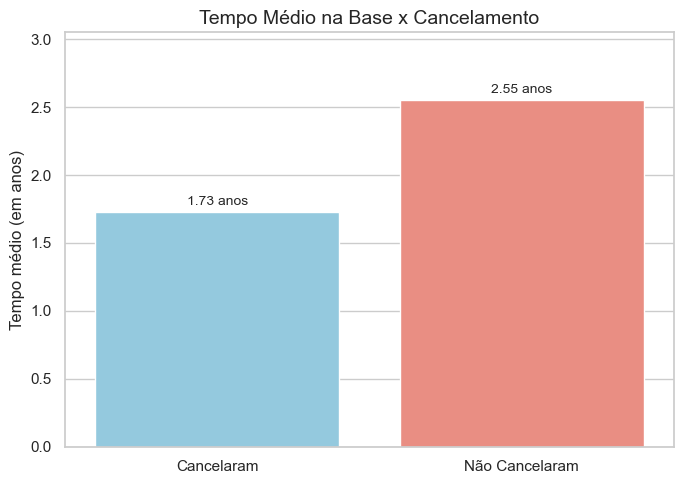

In [28]:
# Traduzir os rótulos para melhor leitura
df_tempo_cancelamento['cancelou'] = df_tempo_cancelamento['cancelou'].map({0: 'Não Cancelaram', 1: 'Cancelaram'})

# Criar gráfico
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    data=df_tempo_cancelamento,
    x='cancelou',
    y='tempo_medio_anos',
    palette=['skyblue', 'salmon']
)

# Título e eixos
plt.title("Tempo Médio na Base x Cancelamento", fontsize=14)
plt.xlabel("")
plt.ylabel("Tempo médio (em anos)")

# Rótulo em cima das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f} anos',
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.05),
                ha='center', fontsize=10)

plt.ylim(0, df_tempo_cancelamento['tempo_medio_anos'].max() + 0.5)
plt.tight_layout()
plt.show()

Clientes com 1.8 meses são aqueles com maior chance de cancelar, logo ,a transição do primeiro para o segundo ano, onde as taxas de cancelamento caem, devem ser tratadas com cuidado extra.

12. Planos com risco (baixa satisfação + sem renovação automática)

In [14]:
query = """
SELECT 
  co.tipo_seguro,
  COUNT(*) AS qtd_planos_risco
FROM contratos co
WHERE co.satisfacao_ultima_avaliacao = 'Baixa'
  AND (co.renovado_automaticamente = 'Não' OR co.renovado_automaticamente = 0 OR co.renovado_automaticamente IS NULL)
GROUP BY co.tipo_seguro
ORDER BY qtd_planos_risco DESC
"""
df_planos_risco = pd.read_sql_query(query, conn)
print(df_planos_risco)

   tipo_seguro  qtd_planos_risco
0  Empresarial               426
1         Auto               412
2         Vida               405
3  Residencial               401
4        Saúde               394


Apesar de serem menos recorrentes entre os clientes, os planos empresariais e auto possuem a maior quantidade de avaliações negativas e ausência de renovação automática.

13. Clientes que cancelaram pelo App: idade média e avaliação média

In [15]:
query = """
SELECT 
  ROUND(AVG((strftime('%Y', 'now') - strftime('%Y', c.data_nascimento))), 2) AS idade_media,
  ROUND(AVG(
    CASE 
      WHEN ca.avaliacao_experiencia_cancelamento = 'Boa' THEN 3
      WHEN ca.avaliacao_experiencia_cancelamento = 'Neutra' THEN 2
      WHEN ca.avaliacao_experiencia_cancelamento = 'Ruim' THEN 1
      ELSE NULL
    END
  ), 2) AS avaliacao_media
FROM cancelamentos ca
JOIN contratos co ON ca.id_contrato = co.id_contrato
JOIN clientes c ON co.id_cliente = c.id_cliente
WHERE ca.canal_cancelamento = 'App'
"""
df_cancel_app = pd.read_sql_query(query, conn)
print(df_cancel_app)

   idade_media  avaliacao_media
0        49.61             2.01


In [26]:
query = """
WITH avaliacoes_convertidas AS (
  SELECT 
    co.id_cliente,
    ca.canal_cancelamento,
    ROUND(AVG(
      CASE 
        WHEN ca.avaliacao_experiencia_cancelamento = 'Boa' THEN 3
        WHEN ca.avaliacao_experiencia_cancelamento = 'Neutra' THEN 2
        WHEN ca.avaliacao_experiencia_cancelamento = 'Ruim' THEN 1
        ELSE NULL
      END
    ), 2) AS avaliacao_media,
    ROUND(AVG((strftime('%Y', 'now') - strftime('%Y', c.data_nascimento))), 2) AS idade_media
  FROM cancelamentos ca
  JOIN contratos co ON ca.id_contrato = co.id_contrato
  JOIN clientes c ON co.id_cliente = c.id_cliente
  GROUP BY 
    CASE 
      WHEN ca.canal_cancelamento = 'App' THEN 'App'
      ELSE 'Geral'
    END
),
comparativo AS (
  SELECT 
    CASE 
      WHEN canal_cancelamento = 'App' THEN 'Cancelou pelo App'
      ELSE 'Todos os Cancelamentos'
    END AS grupo,
    idade_media,
    avaliacao_media
  FROM avaliacoes_convertidas
)
SELECT * FROM comparativo;
"""

df_comparativo_idade_avaliacao = pd.read_sql_query(query, conn)
print(df_comparativo_idade_avaliacao)

                    grupo  idade_media  avaliacao_media
0       Cancelou pelo App        49.61             2.01
1  Todos os Cancelamentos        49.99             2.03


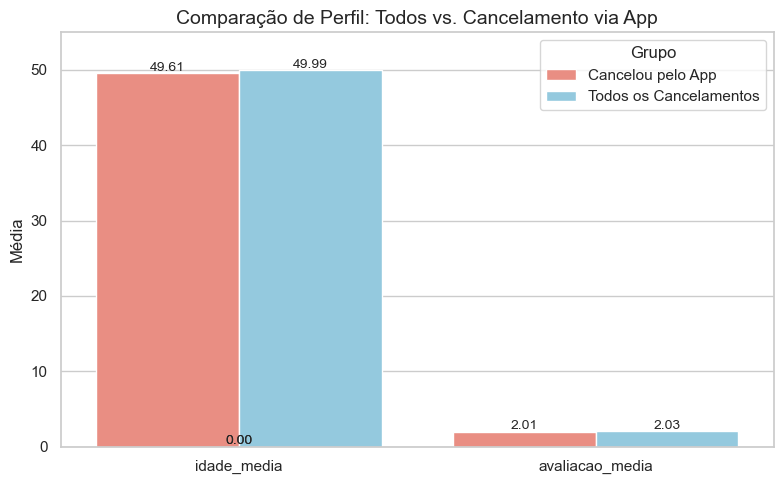

In [27]:
# Reestruturar os dados para gráfico
df_melt = df_comparativo_idade_avaliacao.melt(
    id_vars='grupo',
    var_name='Métrica',
    value_name='Valor'
)

# Cores por grupo
palette = {
    'Cancelou pelo App': 'salmon',
    'Todos os Cancelamentos': 'skyblue'
}

# Criar gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_melt,
    x='Métrica',
    y='Valor',
    hue='grupo',
    palette=palette
)

plt.title("Comparação de Perfil: Todos vs. Cancelamento via App", fontsize=14)
plt.ylabel("Média")
plt.xlabel("")

# Adiciona os valores no topo das barras
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height() + 0.3),
                ha='center', fontsize=10)

plt.ylim(0, df_melt['Valor'].max() + 5)
plt.legend(title='Grupo')
plt.tight_layout()
plt.show()

A quantidade de avaliações positivas entre os clientes que cancelam pelo app pode indicar que, apesar deles gostarem do serviço, a experiência entre os mais velhos com ele não é satisfatória.

14.  Ranking proporcional de cancelamento por profissão

In [16]:
query = """
WITH total_clientes AS (
  SELECT profissao, COUNT(*) AS total
  FROM clientes
  GROUP BY profissao
),
cancelamentos_profissao AS (
  SELECT c.profissao, COUNT(DISTINCT co.id_cliente) AS total_cancelamentos
  FROM cancelamentos ca
  JOIN contratos co ON ca.id_contrato = co.id_contrato
  JOIN clientes c ON co.id_cliente = c.id_cliente
  GROUP BY c.profissao
)
SELECT
  tc.profissao,
  tc.total,
  COALESCE(cp.total_cancelamentos, 0) AS total_cancelamentos,
  ROUND(COALESCE(cp.total_cancelamentos, 0) * 1.0 / tc.total, 4) AS taxa_cancelamento
FROM total_clientes tc
LEFT JOIN cancelamentos_profissao cp ON tc.profissao = cp.profissao
ORDER BY taxa_cancelamento DESC, total_cancelamentos DESC
"""
df_ranking_profissao = pd.read_sql_query(query, conn)
print(df_ranking_profissao)

                               profissao  total  total_cancelamentos  \
0                      Lutador de karatê      6                    6   
1                                   Ator      5                    5   
2    Broker/Corretor da bolsa de valores      4                    4   
3                         Cerimonialista      4                    4   
4                              Figurante      4                    4   
..                                   ...    ...                  ...   
743       Tecnólogo em navegação fluvial      1                    0   
744            Tecnólogo em silvicultura      1                    0   
745             Vigilante noturno/diurno      5                    0   
746                          Webdesigner      5                    0   
747                   Árbitro e mediador      2                    0   

     taxa_cancelamento  
0                  1.0  
1                  1.0  
2                  1.0  
3                  1.0  
4         

Deve-se monitorar com atenção extra profissões com taxa de cancelamento superiores a 50%, especialmente aquelas com 100%. Inicialmente, não existe nenhuma relevância entre os tipos e especialidades das profissões e o cancelamento dos serviços.

15. Troca de plano durante o cancelamento

In [22]:
# 1. Defina a query
query = """
WITH clientes_contratos AS (
  SELECT 
    id_cliente,
    COUNT(DISTINCT id_contrato) AS qtd_contratos
  FROM contratos
  GROUP BY id_cliente
),
clientes_trocaram_plano AS (
  SELECT 
    cc.id_cliente,
    CASE 
      WHEN cc.qtd_contratos > 1 THEN 1
      ELSE 0
    END AS trocou_plano
  FROM clientes_contratos cc
),
cancelamentos_com_cliente AS (
  SELECT DISTINCT
    co.id_cliente,
    1 AS cancelou
  FROM cancelamentos ca
  JOIN contratos co ON ca.id_contrato = co.id_contrato
),
base_final AS (
  SELECT 
    ctp.id_cliente,
    ctp.trocou_plano,
    COALESCE(cc.cancelou, 0) AS cancelou
  FROM clientes_trocaram_plano ctp
  LEFT JOIN cancelamentos_com_cliente cc ON ctp.id_cliente = cc.id_cliente
)
SELECT 
  trocou_plano,
  COUNT(*) AS total_clientes,
  SUM(cancelou) AS total_cancelamentos,
  ROUND(1.0 * SUM(cancelou) / COUNT(*), 4) AS taxa_cancelamento
FROM base_final
GROUP BY trocou_plano
ORDER BY trocou_plano DESC;
"""

# 2. Rode a query
df_troca_cancelamento = pd.read_sql_query(query, conn)

# 3. Print amigável
print("Efeito da troca de plano no churn:\n")
print(df_troca_cancelamento.to_string(index=False))

Efeito da troca de plano no churn:

 trocou_plano  total_clientes  total_cancelamentos  taxa_cancelamento
            1            3464                 1754             0.5064
            0            1085                  219             0.2018


C:\Users\Aluno\AppData\Local\Temp\ipykernel_16092\1003829721.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


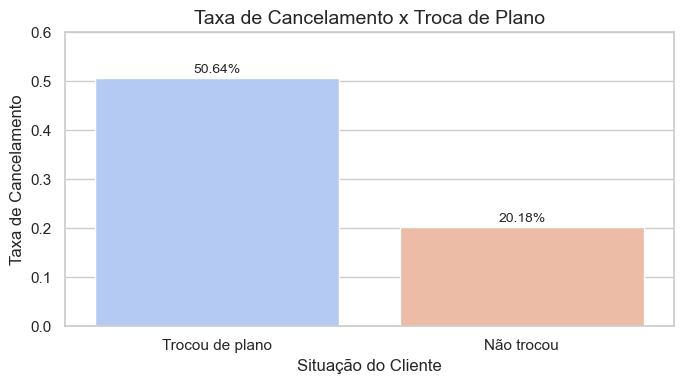

In [23]:
# Configurações de estilo
sns.set(style="whitegrid")

# Mapeando rótulos mais amigáveis
df_troca_cancelamento["status_troca"] = df_troca_cancelamento["trocou_plano"].map({
    1: "Trocou de plano",
    0: "Não trocou"
})

# Ordenar para garantir consistência visual
df_troca_cancelamento = df_troca_cancelamento.sort_values(by="taxa_cancelamento", ascending=False)

# Criar o gráfico
plt.figure(figsize=(7, 4))
ax = sns.barplot(
    data=df_troca_cancelamento,
    x="status_troca",
    y="taxa_cancelamento",
    palette="coolwarm"
)

# Títulos e rótulos
plt.title("Taxa de Cancelamento x Troca de Plano", fontsize=14)
plt.xlabel("Situação do Cliente")
plt.ylabel("Taxa de Cancelamento")

# Adicionar os valores no topo das barras
for i, row in df_troca_cancelamento.iterrows():
    ax.text(i, row["taxa_cancelamento"] + 0.01, f"{row['taxa_cancelamento']:.2%}", ha='center', fontsize=10)

plt.ylim(0, 0.6)
plt.tight_layout()
plt.show()

Podemos concluir que clientes que trocaram de plano tem 2 vezes e meia mais vezes chances de cancelar, logo, isso pode indicar que a troca de planos é um sinal de insatisfação e consequente cancelamento. Apesar dos consumidores poderem estar apenas testando outras alternativas, muitos deles apresentam tendências a abandonar o serviço e devem ser monitorados.

16. Tempo médio até cancelamento por canal de venda

In [18]:
query = """
WITH tempo_cancelamento AS (
  SELECT 
    co.id_contrato,
    co.canal_venda,
    julianday(ca.data_cancelamento) - julianday(co.data_inicio) AS dias_ate_cancelar
  FROM cancelamentos ca
  JOIN contratos co ON ca.id_contrato = co.id_contrato
  WHERE ca.data_cancelamento IS NOT NULL
)
SELECT 
  canal_venda,
  ROUND(AVG(dias_ate_cancelar), 2) AS tempo_medio_dias,
  COUNT(*) AS total_cancelamentos
FROM tempo_cancelamento
GROUP BY canal_venda
ORDER BY tempo_medio_dias ASC;
"""

df_tempo_cancelamento_canal = pd.read_sql_query(query, conn)
print(df_tempo_cancelamento_canal.to_string(index=False))

   canal_venda  tempo_medio_dias  total_cancelamentos
           App            264.64                  622
          Site            265.79                  628
Agência Física            276.02                  653
      Corretor            281.26                  617


C:\Users\Aluno\AppData\Local\Temp\ipykernel_16092\1173378390.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


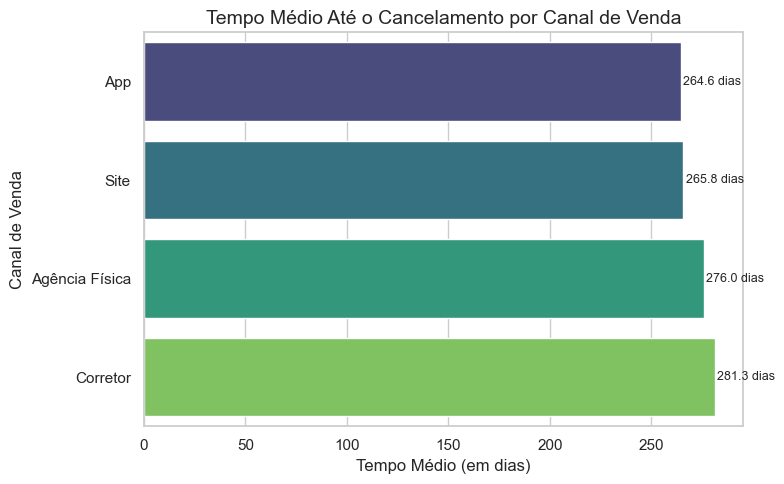

In [20]:
# Configurar o estilo do gráfico
sns.set(style="whitegrid")

# Ordenar o DataFrame pelo tempo médio
df_tempo_cancelamento_canal = df_tempo_cancelamento_canal.sort_values(by="tempo_medio_dias")

# Criar o gráfico
plt.figure(figsize=(8, 5))
ax = sns.barplot(
    data=df_tempo_cancelamento_canal,
    x="tempo_medio_dias",
    y="canal_venda",
    palette="viridis"
)

# Títulos e rótulos
plt.title("Tempo Médio Até o Cancelamento por Canal de Venda", fontsize=14)
plt.xlabel("Tempo Médio (em dias)")
plt.ylabel("Canal de Venda")

# Mostrar os valores no gráfico
for i, row in df_tempo_cancelamento_canal.iterrows():
    ax.text(row["tempo_medio_dias"] + 1, i, f"{row['tempo_medio_dias']:.1f} dias", va='center', fontsize=9)

plt.tight_layout()
plt.show()

Novamente, a amplitude total não é conclusiva por si só, mas mostra que o canal de corretor possui maior período de permanência e menor quantidade de cancelamentos totais, tornando-o menos propenso a sinistros, e mais fácil/barato/tranquilo de gerenciar. 

17. Comparação clientes fiéis x cancelados

In [32]:
query = """
WITH base_clientes AS (
  SELECT 
    c.id_cliente,
    c.genero,
    ROUND((julianday('now') - julianday(c.data_nascimento)) / 365, 1) AS idade,
    c.renda_mensal,
    c.nivel_educacional,
    c.profissao,
    c.qtd_dependentes,
    ROUND((julianday('now') - julianday(c.data_cadastro)) / 365, 2) AS tempo_na_base,
    CASE 
      WHEN ca.id_contrato IS NOT NULL THEN 1
      ELSE 0
    END AS cancelou
  FROM clientes c
  LEFT JOIN contratos co ON c.id_cliente = co.id_cliente
  LEFT JOIN cancelamentos ca ON co.id_contrato = ca.id_contrato
)
SELECT * FROM base_clientes;
"""

df_perfil = pd.read_sql_query(query, conn)


In [33]:
# Clientes que cancelaram
canceladores = df_perfil[df_perfil['cancelou'] == 1]
# Clientes que permaneceram
fieis = df_perfil[df_perfil['cancelou'] == 0]

# Comparação numérica (idade, renda, dependentes, tempo_na_base)
medias_canceladores = canceladores[['idade', 'renda_mensal', 'qtd_dependentes', 'tempo_na_base']].mean()
medias_fieis = fieis[['idade', 'renda_mensal', 'qtd_dependentes', 'tempo_na_base']].mean()

print("Canceladores:\n", medias_canceladores)
print("\nFieis:\n", medias_fieis)

Canceladores:
 idade                 49.969802
renda_mensal       10697.695520
qtd_dependentes        1.476190
tempo_na_base          2.532206
dtype: float64

Fieis:
 idade                 50.044467
renda_mensal       10852.507483
qtd_dependentes        1.498641
tempo_na_base          2.550819
dtype: float64


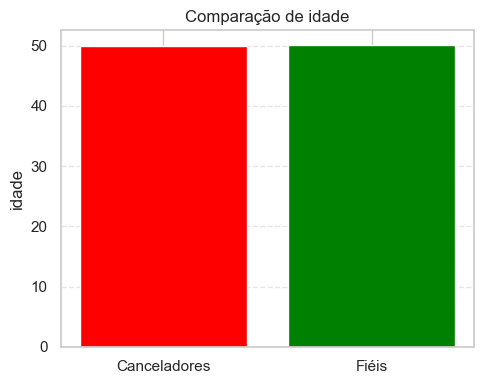

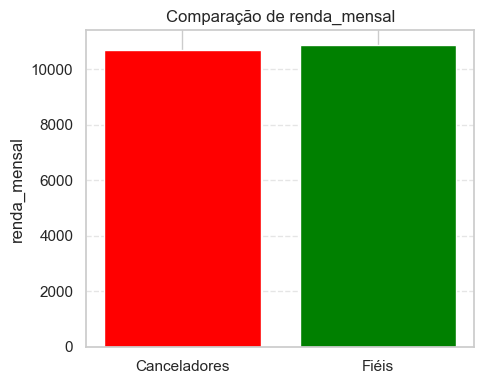

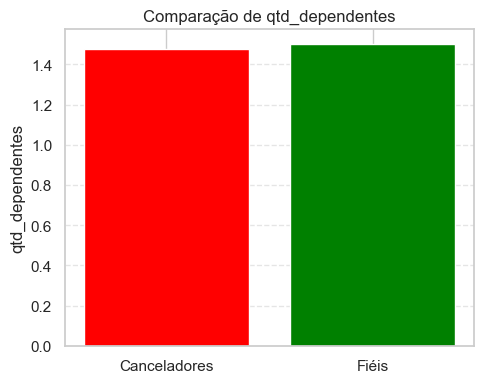

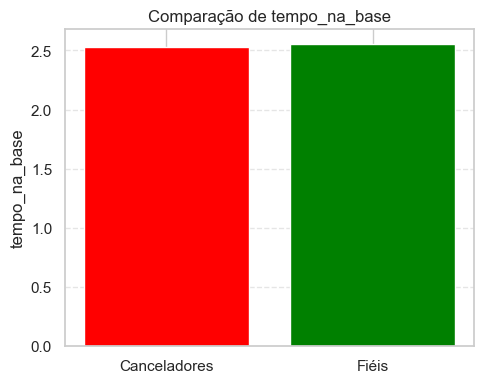

In [38]:
for coluna in medias.index:
    plt.figure(figsize=(5, 4))
    plt.bar(['Canceladores', 'Fiéis'], medias.loc[coluna], color=['red', 'green'])
    plt.title(f'Comparação de {coluna}')
    plt.ylabel(coluna)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

Clientes fiéis tendem a possuir uma quantia levemente maior de tempo na base, dependentes, renda mensal e idade geral, logo, quanto maiores esses valores, maior deve ser o nível de observação por parte do time de marketing.